In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json
import os
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, Subset

# Recreate dataset
class KidneyDataset(Dataset):
    def __init__(self, labels_list, data_dir, transform=None):
        self.labels_list = labels_list
        self.data_dir = data_dir
        self.transform = transform
        self.label_to_idx = {'kidney_normal': 0, 'kidney_tumor': 1}
    
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        item = self.labels_list[idx]
        img_path = os.path.join(self.data_dir, item['filename'])
        image = Image.open(img_path).convert('RGB')
        label = self.label_to_idx[item['label']]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Load labels
with open('data/test_labels.json', 'r') as f:
    test_labels = json.load(f)

# Transforms
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Create test dataset
test_dataset = KidneyDataset(test_labels, 'data/test', val_transform)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
model = model.to(device)
model.eval()

print("Dataset and model loaded")

Dataset and model loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000238418578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

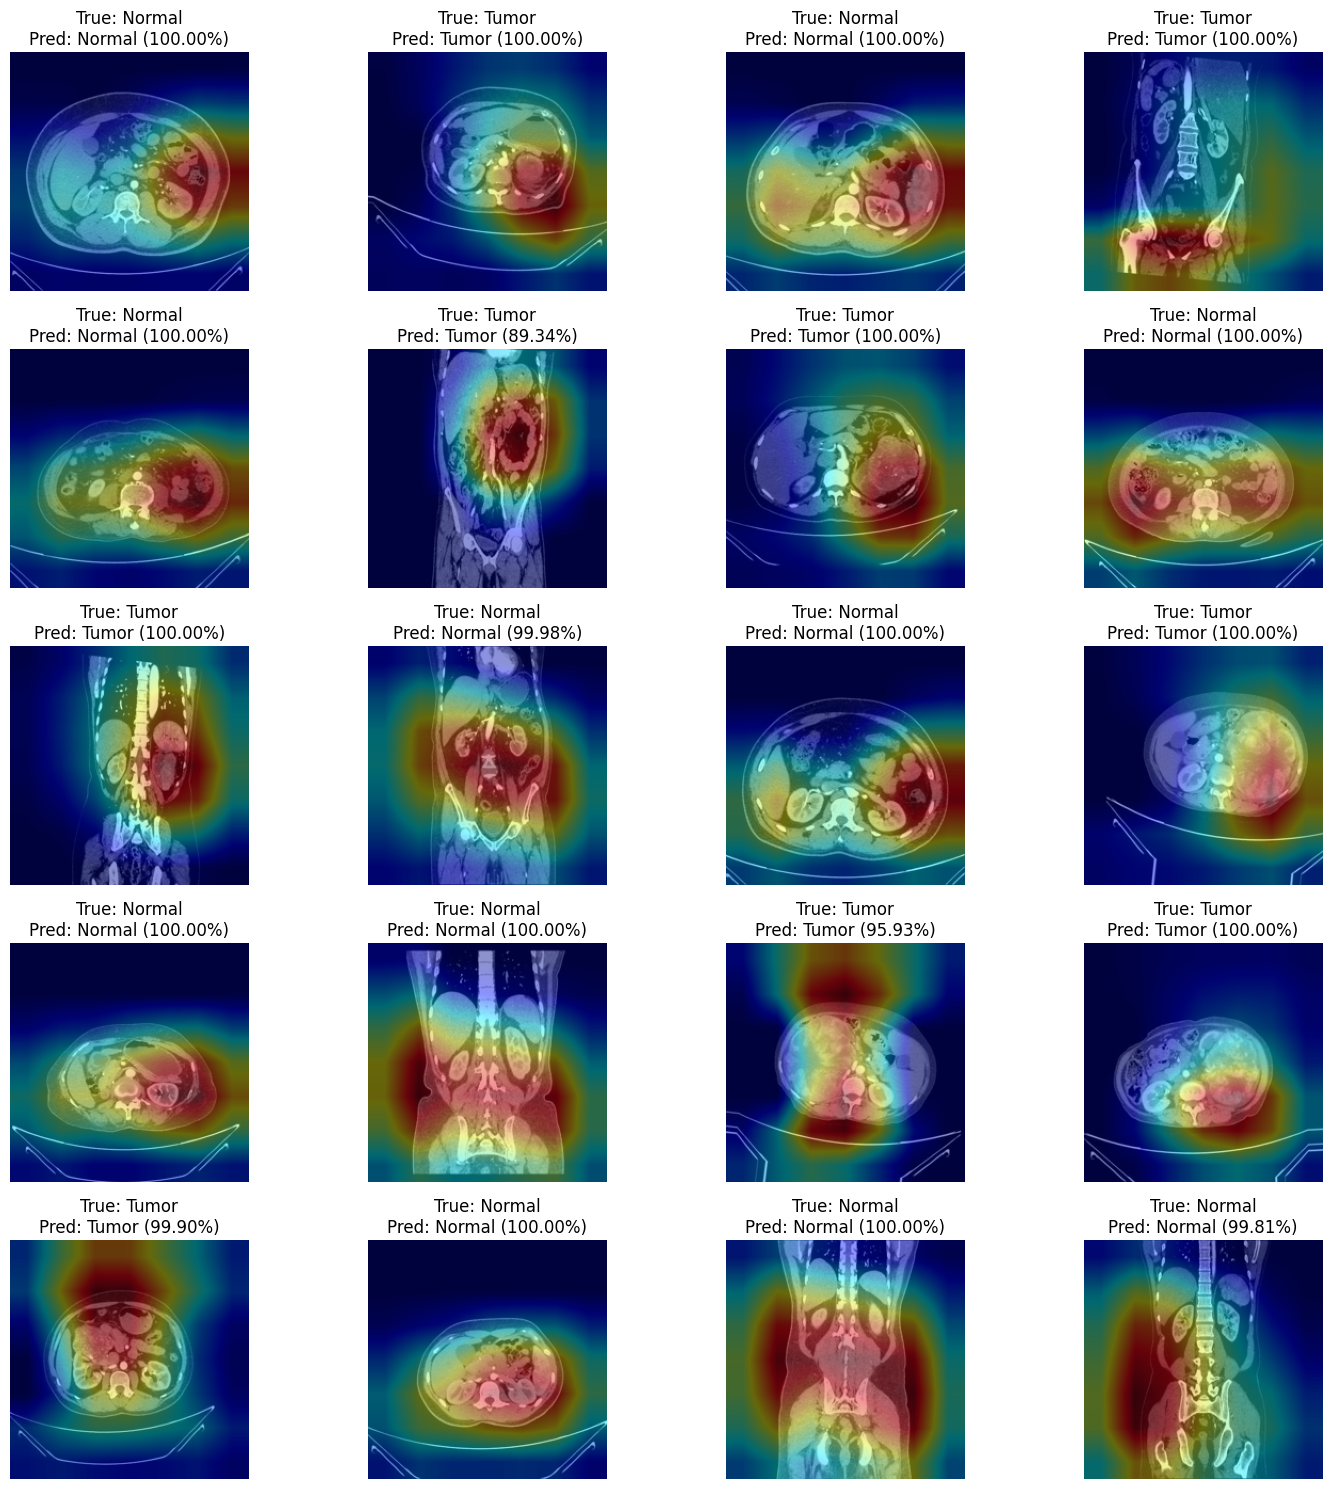

Grad-CAM visualizations saved


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# Load best model
from torchvision import models
import json
from torch.utils.data import DataLoader, Subset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load('checkpoints/best_model.pth'))
model = model.to(device)
model.eval()

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, x, class_idx):
        self.model.zero_grad()
        output = self.model(x)
        
        # Backward pass
        target = output[0, class_idx]
        target.backward()
        
        # Compute CAM
        gradients = self.gradients[0]
        activations = self.activations[0]
        
        weights = gradients.mean(dim=(1, 2))
        cam = torch.zeros(activations.shape[1:], device=device)
        
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        cam = F.relu(cam)
        cam = cam / (cam.max() + 1e-8)
        
        return cam.cpu().numpy()

# Initialize Grad-CAM
grad_cam = GradCAM(model, model.layer4[1].conv2)

# Get some test samples
from torch.utils.data import Subset
test_subset = Subset(test_dataset, range(0, 20))
test_subset_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

# Visualize predictions with Grad-CAM
fig, axes = plt.subplots(5, 4, figsize=(15, 15))
axes = axes.flatten()

idx = 0
for images, labels in test_subset_loader:
    if idx >= 20:
        break
    
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred].item()
    
    # Generate CAM
    cam = grad_cam.generate_cam(images, pred)
    
    # Get original image
    img_array = images[0].cpu().numpy().transpose(1, 2, 0)
    img_array = (img_array - img_array.min()) / (img_array.max() - img_array.min())
    
    # Resize CAM to match image
    cam_resized = cv2.resize(cam, (img_array.shape[1], img_array.shape[0]))
    
    # Overlay CAM on image
    cam_color = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    cam_color = cv2.cvtColor(cam_color, cv2.COLOR_BGR2RGB)
    
    overlay = 0.6 * img_array + 0.4 * (cam_color / 255)
    
    # Plot
    label_text = 'Normal' if labels[0].item() == 0 else 'Tumor'
    pred_text = 'Normal' if pred == 0 else 'Tumor'
    
    axes[idx].imshow(overlay, cmap='gray')
    axes[idx].set_title(f'True: {label_text}\nPred: {pred_text} ({confidence:.2%})')
    axes[idx].axis('off')
    
    idx += 1

plt.tight_layout()
plt.savefig('results/gradcam_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("Grad-CAM visualizations saved")